# Category-based Subspace Attention Network

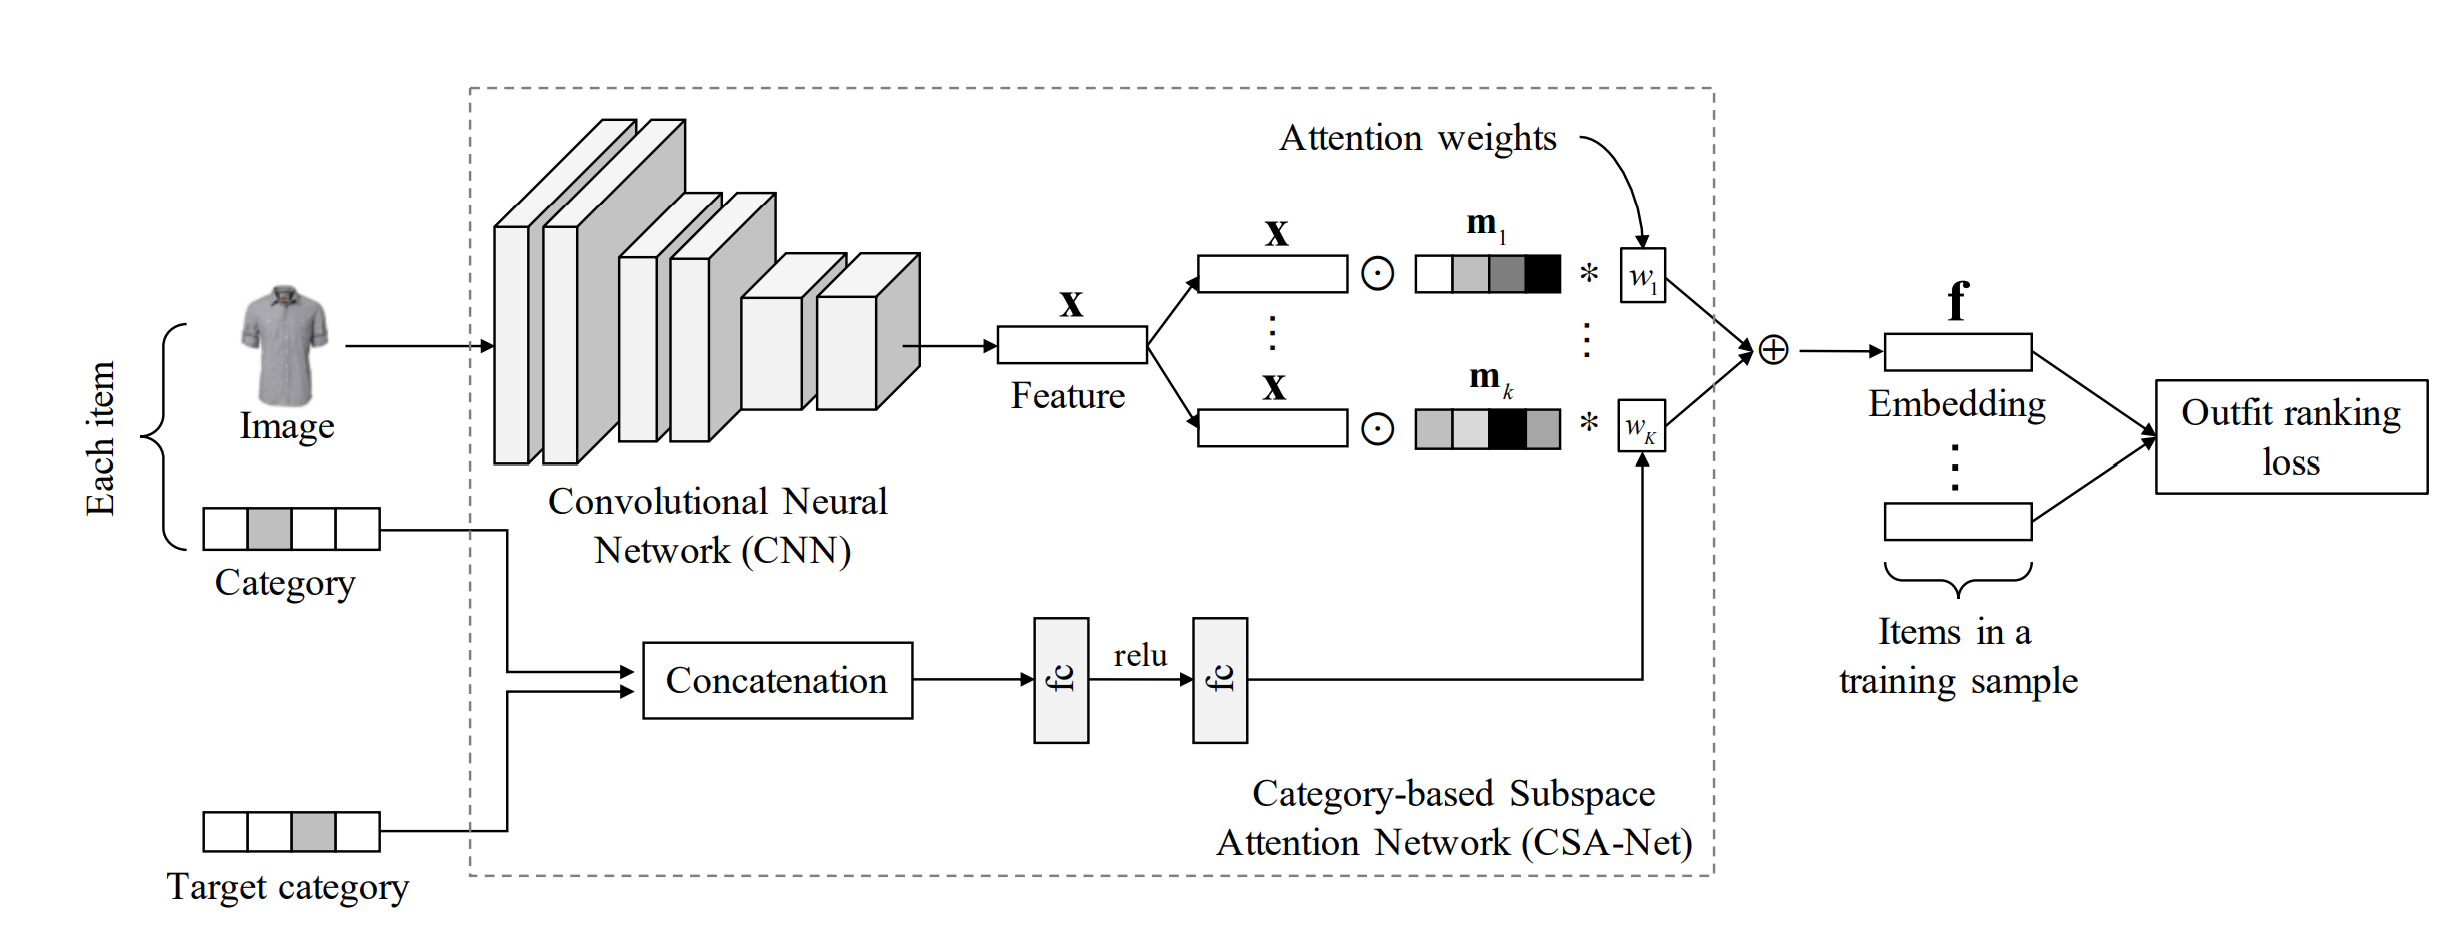

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
from collections import Counter
from PIL import Image
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tqdm import tqdm
import pickle

import sys
# sys.path.insert(0, "/recsys_data/RecSys/fashion/automl/efficientnetv2")
# import effnetv2_model

%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [3]:
base_dir = "/recsys_data/RecSys/fashion/polyvore-dataset/polyvore_outfits"
data_type = "nondisjoint" # "nondisjoint", "disjoint"
train_dir = os.path.join(base_dir, data_type)
image_dir = os.path.join(base_dir, "images")
embed_dir = "/recsys_data/RecSys/fashion/polyvore-dataset/precomputed"
train_json = "train.json"
valid_json = "valid.json"
test_json = "test.json"

train_file = "compatibility_train.txt"
valid_file = "compatibility_valid.txt"
test_file = "compatibility_test.txt"
item_file = "polyvore_item_metadata.json"
outfit_file = "polyvore_outfit_titles.json"

In [4]:
with open(os.path.join(train_dir, train_json), 'r') as fr:
    train_pos = json.load(fr)
    
with open(os.path.join(train_dir, valid_json), 'r') as fr:
    valid_pos = json.load(fr)
    
with open(os.path.join(train_dir, test_json), 'r') as fr:
    test_pos = json.load(fr)
    
with open(os.path.join(base_dir, item_file), 'r') as fr:
    pv_items = json.load(fr)
    
print(f"Total {len(train_pos)}, {len(valid_pos)}, {len(test_pos)} outfits in train, validation and test split, respectively")

Total 53306, 5000, 10000 outfits in train, validation and test split, respectively
